In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [2]:
pd.set_option('display.max_columns', None)

# Import Preprocessed Data

In [3]:
data = pd.read_csv('../data/preprocess_data.csv')
data = data.sample(frac=1).reset_index(drop=True)

idx = data['Yards']>=0
data = data[idx]

print(data.shape)
data.head()

(27678, 62)


,GameId,PlayId,NflIdRusher,DisplayName,Season,Yards,X,Y,YardLine,HomeScoreBeforePlay,VisitorScoreBeforePlay,DefendersInTheBox_IMP,PlayerWeight,PlayerHeight_ADJ,Temperature_IMP,Humidity_IMP,WindSpeed_IMP,Team_away,Team_home,Team_nan,Quarter_1.0,Quarter_2.0,Quarter_3.0,Quarter_4.0,Quarter_5.0,Quarter_nan,Down_1.0,Down_2.0,Down_3.0,Down_4.0,Down_nan,OffenseFormation_ACE,OffenseFormation_EMPTY,OffenseFormation_I_FORM,OffenseFormation_JUMBO,OffenseFormation_PISTOL,OffenseFormation_SHOTGUN,OffenseFormation_SINGLEBACK,OffenseFormation_WILDCAT,OffenseFormation_nan,PlayDirection_left,PlayDirection_right,PlayDirection_nan,StadiumType_ADJ_Indoor,StadiumType_ADJ_Outdoor,StadiumType_ADJ_Retractable Roof,StadiumType_ADJ_Retractable Roof - Closed,StadiumType_ADJ_Retractable Roof - Opened,StadiumType_ADJ_nan,GameWeather_ADJ_Clear,GameWeather_ADJ_Cloudy,GameWeather_ADJ_Indoor,GameWeather_ADJ_Light Rain,GameWeather_ADJ_Mostly Clear,GameWeather_ADJ_Mostly Cloudy,GameWeather_ADJ_Mostly Sunny,GameWeather_ADJ_Partly Cloudy,GameWeather_ADJ_Partly Sunny,GameWeather_ADJ_Rain,GameWeather_ADJ_Snow,GameWeather_ADJ_Sunny,GameWeather_ADJ_nan
0,2018112500,20181125002022,2532899,Doug Martin,2018,14,51.29,28.91,37,13,7,5,210,69,60.0,54.0,7.0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2017110501,20171105012465,2506404,Frank Gore,2017,1,97.71,28.10,18,7,10,7,212,69,84.0,62.0,10.0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2018120213,20181202132252,2560835,Rashaad Penny,2018,20,81.55,25.35,20,20,3,6,220,71,45.0,81.0,2.0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2018092312,20180923122995,2558865,Chris Carson,2018,5,78.02,30.82,28,17,6,6,222,71,61.0,59.0,4.0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2017091800,20170918002074,2555460,Paul Perkins,2017,3,72.89,31.52,41,7,17,7,208,71,72.0,80.0,5.0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


# Split Data (Training, Testing, CFV)

Testing: 2019 season  
Training/CFV: 2017 & 2018 seasons

In [4]:
data.groupby('Season')['PlayId'].count()/data.shape[0]

Season
2017    0.379652
2018    0.364983
2019    0.255365
Name: PlayId, dtype: float64

In [5]:
idx = data['Season'] != 2019

train_data = data[idx].reset_index(drop=True)
test_data = data[~idx].reset_index(drop=True)

In [6]:
train_data.head()

,GameId,PlayId,NflIdRusher,DisplayName,Season,Yards,X,Y,YardLine,HomeScoreBeforePlay,VisitorScoreBeforePlay,DefendersInTheBox_IMP,PlayerWeight,PlayerHeight_ADJ,Temperature_IMP,Humidity_IMP,WindSpeed_IMP,Team_away,Team_home,Team_nan,Quarter_1.0,Quarter_2.0,Quarter_3.0,Quarter_4.0,Quarter_5.0,Quarter_nan,Down_1.0,Down_2.0,Down_3.0,Down_4.0,Down_nan,OffenseFormation_ACE,OffenseFormation_EMPTY,OffenseFormation_I_FORM,OffenseFormation_JUMBO,OffenseFormation_PISTOL,OffenseFormation_SHOTGUN,OffenseFormation_SINGLEBACK,OffenseFormation_WILDCAT,OffenseFormation_nan,PlayDirection_left,PlayDirection_right,PlayDirection_nan,StadiumType_ADJ_Indoor,StadiumType_ADJ_Outdoor,StadiumType_ADJ_Retractable Roof,StadiumType_ADJ_Retractable Roof - Closed,StadiumType_ADJ_Retractable Roof - Opened,StadiumType_ADJ_nan,GameWeather_ADJ_Clear,GameWeather_ADJ_Cloudy,GameWeather_ADJ_Indoor,GameWeather_ADJ_Light Rain,GameWeather_ADJ_Mostly Clear,GameWeather_ADJ_Mostly Cloudy,GameWeather_ADJ_Mostly Sunny,GameWeather_ADJ_Partly Cloudy,GameWeather_ADJ_Partly Sunny,GameWeather_ADJ_Rain,GameWeather_ADJ_Snow,GameWeather_ADJ_Sunny,GameWeather_ADJ_nan
0,2017121709,20171217092494,2540175,Le'Veon Bell,2017,3,101.94,27.46,3,17,16,6,225,73,42.0,62.0,4.0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,2018122313,20181223130105,2560862,Jaylen Samuels,2018,2,75.11,35.43,41,0,0,6,225,72,68.0,71.0,10.0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2018100700,20181007000256,2507999,Chris Ivory,2018,3,51.56,28.38,38,0,0,7,223,72,62.0,96.0,8.0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2018100705,20181007054249,2557917,Kareem Hunt,2018,7,113.37,29.09,2,30,14,6,216,71,58.0,90.0,5.0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2018121601,20181216011056,2556466,Peyton Barber,2018,4,96.25,29.08,10,0,0,6,225,71,43.0,97.0,0.0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [6]:
drop_cols = ['GameId', 'PlayId', 'NflIdRusher', 'DisplayName', 'Season', 'Yards']
quant_cols = ['X', 'Y', 'YardLine', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'DefendersInTheBox_IMP',
             'PlayerWeight', 'PlayerHeight_ADJ', 'Temperature_IMP', 'Humidity_IMP', 'WindSpeed_IMP']
X_train = train_data.drop(drop_cols, axis=1)
X_test = test_data.drop(drop_cols, axis=1)

y_train = train_data['Yards']
y_test = test_data['Yards']

# Build Models

In [38]:
# Model config
METRICS = ['r2', 'explained_variance','neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
CV = 5
N_JOBS = -1
RETURN_TRAIN_SCORE = True
RETURN_ESTIMATOR = True
RANDOM_STATE = 0
N_ITER = 1000

### Decision Tree: Baseline model with default parameters

In [31]:
dtr = DecisionTreeRegressor()

dtr_cfv_results = cross_validate(dtr, X_train, y_train, 
                                 scoring=METRICS, 
                                 cv=CV, n_jobs=N_JOBS,
                                 return_train_score=RETURN_TRAIN_SCORE, return_estimator=RETURN_ESTIMATOR)
dtr_cfv_results

{'fit_time': array([0.24761295, 0.25248003, 0.23657107, 0.24268913, 0.233711  ]),
 'score_time': array([0.00456595, 0.00634408, 0.00490093, 0.00519991, 0.00686407]),
 'estimator': [DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor(),
  DecisionTreeRegressor()],
 'test_r2': array([-1.23274021, -1.40375323, -1.24879674, -0.98516474, -1.3874654 ]),
 'train_r2': array([1., 1., 1., 1., 1.]),
 'test_explained_variance': array([-1.22820694, -1.40122512, -1.2438108 , -0.98440449, -1.3764655 ]),
 'train_explained_variance': array([1., 1., 1., 1., 1.]),
 'test_neg_root_mean_squared_error': array([-9.8365709 , -9.48545197, -9.73768023, -9.29762873, -9.15683607]),
 'train_neg_root_mean_squared_error': array([-0., -0., -0., -0., -0.]),
 'test_neg_mean_absolute_percentage_error': array([-2.59596136e+15, -2.43863037e+15, -2.42770460e+15, -2.22557798e+15,
        -2.37416836e+15]),
 'train_neg_mean_absolute_percentage_error': array([-0., -0., -0., -

**Conclusion**: Baseline model is showing high variance since the training folds are significantly outperforming the validation folds. Next step is to optimize.

### Decision Tree: Optimized via Random Search

In [39]:
dtr = DecisionTreeRegressor()

parameters = {'max_depth':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
              'min_samples_split':[2, 3, 4, 5, 10, 15, 20, 25],
              'min_samples_leaf':[2, 3, 4, 5, 10, 15, 20, 25],
              'max_features':['auto', 'sqrt', 'log2']}

rand_search_dt = RandomizedSearchCV(estimator=dtr, param_distributions=parameters, 
                                    n_iter=N_ITER, scoring='explained_variance', 
                                    cv=CV, n_jobs=N_JOBS, refit=True,
                                    random_state=RANDOM_STATE,
                                    return_train_score=RETURN_TRAIN_SCORE)
search = rand_search_dt.fit(X_train, y_train)

In [40]:
search.best_score_

-0.0035430930816856333

In [41]:
search.best_params_

{'min_samples_split': 4,
 'min_samples_leaf': 25,
 'max_features': 'sqrt',
 'max_depth': 10}

[CV 2/5] END max_depth=70, max_features=log2, min_samples_leaf=4, min_samples_split=15; explained_variance: (train=0.220, test=-0.211) neg_mean_absolute_percentage_error: (train=-1753124875309269.250, test=-2079202795751221.750) neg_root_mean_squared_error: (train=-5.660, test=-6.734) r2: (train=0.220, test=-0.211) total time=   0.1s
[CV 1/5] END max_depth=50, max_features=auto, min_samples_leaf=15, min_samples_split=20; explained_variance: (train=0.208, test=-0.170) neg_mean_absolute_percentage_error: (train=-1665827116879494.750, test=-2262951499176018.500) neg_root_mean_squared_error: (train=-5.597, test=-7.122) r2: (train=0.208, test=-0.171) total time=   0.3s
[CV 3/5] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20; explained_variance: (train=0.297, test=-0.286) neg_mean_absolute_percentage_error: (train=-1442829413962483.250, test=-2318021404395545.000) neg_root_mean_squared_error: (train=-5.295, test=-7.364) r2: (train=0.297, test=-0.286) total time

[CV 3/5] END max_depth=70, max_features=log2, min_samples_leaf=4, min_samples_split=15; explained_variance: (train=0.227, test=-0.203) neg_mean_absolute_percentage_error: (train=-1736671940899962.250, test=-2364676774236289.000) neg_root_mean_squared_error: (train=-5.551, test=-7.121) r2: (train=0.227, test=-0.203) total time=   0.1s
[CV 4/5] END max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=4; explained_variance: (train=0.498, test=-0.440) neg_mean_absolute_percentage_error: (train=-779917402718253.500, test=-2278926923106368.500) neg_root_mean_squared_error: (train=-4.453, test=-7.918) r2: (train=0.498, test=-0.440) total time=   0.4s
[CV 3/5] END max_depth=80, max_features=sqrt, min_samples_leaf=10, min_samples_split=2; explained_variance: (train=0.167, test=-0.111) neg_mean_absolute_percentage_error: (train=-1821150103696798.250, test=-2242324923617136.000) neg_root_mean_squared_error: (train=-5.764, test=-6.846) r2: (train=0.167, test=-0.111) total time=  

[CV 1/5] END max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=20; explained_variance: (train=0.336, test=-0.312) neg_mean_absolute_percentage_error: (train=-1271451619668833.500, test=-2309430769139174.500) neg_root_mean_squared_error: (train=-5.125, test=-7.542) r2: (train=0.336, test=-0.312) total time=   0.4s
[CV 4/5] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=20; explained_variance: (train=0.295, test=-0.218) neg_mean_absolute_percentage_error: (train=-1487384375924843.500, test=-2220560406047876.750) neg_root_mean_squared_error: (train=-5.279, test=-7.284) r2: (train=0.295, test=-0.218) total time=   0.3s
[CV 3/5] END max_depth=70, max_features=log2, min_samples_leaf=4, min_samples_split=15;, score=(train=0.212, test=-0.182) total time=   0.1s
[CV 4/5] END max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=20;, score=(train=0.332, test=-0.260) total time=   0.3s
[CV 3/5] END max_depth=20, max_features=auto, 

**Conclusion**: Performance improved but it is still not great (not even positive yet). I will increase complexity by using a random forest model next

### Random Forest: Optimized via Random Search

In [48]:
rfr = RandomForestRegressor()

parameters = {'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
              'max_depth':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
              'min_samples_split':[2, 3, 4, 5, 10, 15, 20, 25],
              'min_samples_leaf':[2, 3, 4, 5, 10, 15, 20, 25],
              'max_features':['auto', 'sqrt', 'log2']}

rand_search_rf = RandomizedSearchCV(estimator=rfr, param_distributions=parameters, 
                                    n_iter=N_ITER, scoring='explained_variance', 
                                    cv=CV, n_jobs=100, refit=True,
                                    random_state=RANDOM_STATE,
                                    return_train_score=RETURN_TRAIN_SCORE)
search = rand_search_rf.fit(X_train, y_train)

In [51]:
search.best_score_

0.01918601241379354

In [50]:
search.best_params_

{'n_estimators': 70,
 'min_samples_split': 25,
 'min_samples_leaf': 25,
 'max_features': 'sqrt',
 'max_depth': 40}

**Conclusion**: Optimized random forest model performed the best but the best score was only slightly above zero (0.02) for the explained variance. This indicates that more sophisticated techniques (e.g. neural networks) and/or more features/data is needed to improve the performance. 

# Evaluate Model on Test data

In [52]:
final_model = search.best_estimator_

In [7]:
test_pred = final_model.predict(X_test)

In [55]:
explained_variance_score(y_test, test_pred)

0.017799890087573766

In [60]:
diff = y_test - test_pred
diff.describe()

count    7068.000000
mean       -0.046851
std         6.374567
min        -7.191296
25%        -3.274580
50%        -1.535974
75%         0.924456
max        85.447181
Name: Yards, dtype: float64

<AxesSubplot:>

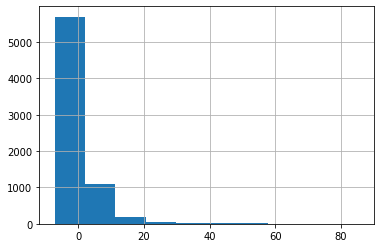

In [61]:
diff.hist()

In [8]:
percent_chg = abs(1-y_test/test_pred)
percent_chg.describe()

count    7068.000000
mean        0.720882
std         1.004292
min         0.000005
25%         0.279094
50%         0.562504
75%         0.821065
max        15.534650
Name: Yards, dtype: float64

<AxesSubplot:title={'center':'Absolute Percent Error Histogram'}, ylabel='Frequency'>

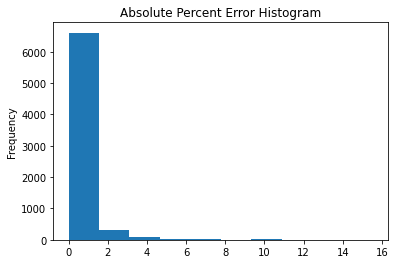

In [16]:
percent_chg.plot(kind='hist',title='Absolute Percent Error Histogram')

**Conclusion**: Overall performance on test data is poor. Explained variance is 0.018 which is similar to the performance on the CFV. Looking at the percent difference between predictions and acuals, we see that the differences are pretty large with the median difference of 56%.

# Output models

In [68]:
filename = '../objects/final_model.pkl'
pickle.dump(final_model, open(filename, 'wb'))

In [4]:
#To load model
filename = '../objects/final_model.pkl'
final_model = pickle.load(open(filename, 'rb'))
final_model.feature_names_in_

# Extract Important Features

In [33]:
sort_idx = np.argsort(final_model.feature_importances_)
important_features_values = final_model.feature_importances_[sort_idx][::-1]
important_features = final_model.feature_names_in_[sort_idx][::-1]
important_features

array(['YardLine', 'X', 'Y', 'PlayerWeight', 'Temperature_IMP',
       'Humidity_IMP', 'VisitorScoreBeforePlay', 'HomeScoreBeforePlay',
       'DefendersInTheBox_IMP', 'WindSpeed_IMP', 'PlayerHeight_ADJ',
       'PlayDirection_left', 'OffenseFormation_JUMBO',
       'OffenseFormation_SINGLEBACK', 'Team_away', 'Team_home',
       'PlayDirection_right', 'Down_1.0', 'Quarter_3.0', 'Down_2.0',
       'OffenseFormation_SHOTGUN', 'Quarter_2.0', 'GameWeather_ADJ_Sunny',
       'Quarter_4.0', 'GameWeather_ADJ_Cloudy', 'Quarter_1.0',
       'OffenseFormation_I_FORM', 'StadiumType_ADJ_Outdoor',
       'GameWeather_ADJ_Clear', 'GameWeather_ADJ_Partly Cloudy',
       'Down_3.0', 'StadiumType_ADJ_Indoor', 'GameWeather_ADJ_Indoor',
       'GameWeather_ADJ_Mostly Cloudy', 'GameWeather_ADJ_Rain',
       'StadiumType_ADJ_Retractable Roof - Closed', 'Down_4.0',
       'StadiumType_ADJ_Retractable Roof', 'OffenseFormation_PISTOL',
       'GameWeather_ADJ_Mostly Sunny', 'GameWeather_ADJ_Partly Sunny',
   

<AxesSubplot:xlabel='Feature'>

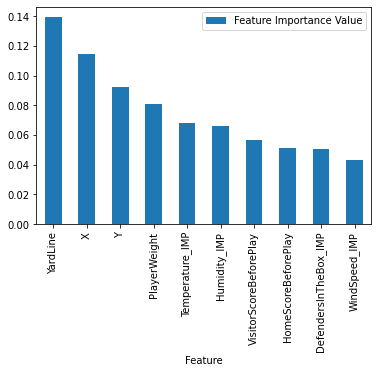

In [41]:
df_feature_importance = pd.DataFrame({'Feature':list(important_features),
                                      'Feature Importance Value':important_features_values})
df_feature_importance[:10].plot.bar(x='Feature')

# Summarize Results

Overall it is difficult to predict the yards a player will rush given the features available in the data. There is high variance in the data which is shown by the poor performance in the CFV and test data (0.019 and 0.018 respectively for explained variance)

The important features for the most part are logical and include the location of the player (x,y coordinates), the player's weight, the weather, the score of the game, and the number of defenders in the box.

Next steps for this model is to develop additional features specifically around the other players on the field since this model focused on the attributes of the rushers. Also more data clean-up could be performed to improve the quality of featuers along with the different normalization techniques (e.g. Yeo-Johnson). Lastly, more complex models (e.g. Neural Networks) can be applied to improve performance.